In [1]:
import matplotlib.pyplot as plt
import matplotlib
import dtale as dt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import IsolationForest
import seaborn as sns

In [2]:
%matplotlib inline


### Importing Data 
This contains all the features, the farming practices, soil, geo info ...

In [3]:
data_raw = catalog.load('merged_yield_2019_and_adoption_survey_enriched')

2021-11-24 00:09:48,863 - kedro.io.data_catalog - INFO - Loading data from `merged_yield_2019_and_adoption_survey_enriched` (CSVDataSet)...


In [4]:
data = data_raw.copy() 
data.columns

Index(['county', 'sub_county', 'ward', 'cluster', 'cluster_lat', 'cluster_lon',
       'distance_to_cluster', 'engagement_year', 'conservation_agriculture',
       'ca_minimum_tilage', 'ca_permanent_soil', 'ca_crop_rotation',
       'agroforestry', 'soil_water_conservation', 'swc_physical',
       'swc_biological', 'isf_pm_soil_testing', 'isf_pm_composting',
       'isf_pm_liming', 'isf_pm_biological_control', 'fertilizer_application',
       'push_pull', 'pp_brachiaria_napier', 'pp_desmodiun', 'pp_grass_crop',
       'integrated_soil_fertility_and_pest_management', 'fertilizer_type',
       'good_agronomic_practices', 'gap_timely_cropping',
       'gap_weed_pest_management', 'gap_seed_selection', 'time', 'crop',
       'total_area', 'pH_2015', 'pH_2019', 'Cgkg_2015', 'Cgkg_2019', 'Ngkg',
       'Pgkg', 'Kmmol+kg', 'Cammol+/kg', 'slope', 'elevation',
       'mean_annual_precipitation_2010_2020', 'mean_temperature_2010-2020',
       'cation_exchange_capacity_ph7'],
      dtype='object')

In [5]:
#All continuous features 
geographic_features = [ 'pH_2019', 'Cgkg_2019', 'Ngkg',
       'Pgkg', 'Kmmol+kg', 'Cammol+/kg', 'slope', 'elevation',
       'mean_annual_precipitation_2010_2020', 'mean_temperature_2010-2020',
       'cation_exchange_capacity_ph7']

#All farming practices
farming_practices_no_fertilizer_type = ['ca_minimum_tilage', 'ca_permanent_soil', 'ca_crop_rotation',
       'agroforestry', 'swc_physical', # We exclude it because it contains nans'fertilizer_application',
       'swc_biological', 'isf_pm_soil_testing', 'isf_pm_composting',
       'isf_pm_liming', 'isf_pm_biological_control','pp_brachiaria_napier', 'pp_desmodiun', 'pp_grass_crop',
       'gap_timely_cropping',
       'gap_weed_pest_management', 'gap_seed_selection']

In [6]:
dt_data = dt.show(data)
dt_data

### Clustering on Soil and topological features

IMPORTANT: This Clustering was done using the soil features which we found later to be unsuitable, all the results in this section should be discarded

In [7]:

clust_data_st = data[geographic_features]
         

In [8]:
std_st = ('std', StandardScaler())
pca_st = ('pca', PCA(n_components=0.99))
agg_st = ('agg_clustering', AgglomerativeClustering(n_clusters=6))

cluster_model_st = agg_st

In [9]:
pipeline_st = Pipeline(steps = [std_st, pca_st, agg_st])

In [10]:
clusters_st = pipeline_st.fit_predict(clust_data_st)

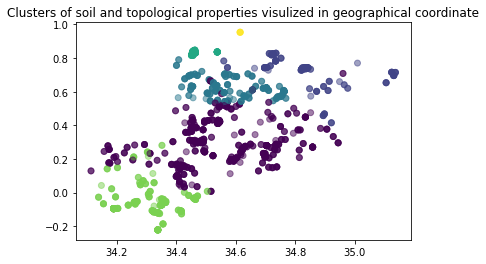

In [11]:
plt.title("Clusters of soil and topological properties visulized in geographical coordinate")
plt.scatter(data['cluster_lon'], data['cluster_lat'], c=clusters_st, alpha=0.5)

In [12]:
data['clusters_st'] = clusters_st

### Clustering farming practices

In [13]:
data_fp = data[farming_practices_no_fertilizer_type]
dt.show(data_fp)



In [14]:
#We find all combinations of fp in the dataset and count the occurence of each combination
count_combinations_fp = data_fp.groupby(data_fp.columns.tolist(),as_index=False).size()
#For each combination we count the number of farming practice it contains
count_combinations_fp['nbr_fp_applied'] = count_combinations_fp[farming_practices_no_fertilizer_type].sum(axis = 1)

dt_count_combinations = dt.show(count_combinations_fp)
dt_count_combinations

In [15]:
data[farming_practices_no_fertilizer_type].sum(axis = 0)

ca_minimum_tilage            1016.0
ca_permanent_soil             793.0
ca_crop_rotation             1129.0
agroforestry                 1029.0
swc_physical                  769.0
swc_biological                699.0
isf_pm_soil_testing           444.0
isf_pm_composting             845.0
isf_pm_liming                  99.0
isf_pm_biological_control     303.0
pp_brachiaria_napier          302.0
pp_desmodiun                  379.0
pp_grass_crop                 291.0
gap_timely_cropping           874.0
gap_weed_pest_management      747.0
gap_seed_selection            537.0
dtype: float64

In [16]:
data

county sub_county            ward  cluster  cluster_lat  cluster_lon  \
0            1         12             121     82.0     0.167889    34.384983   
1            1         12             121    110.0     0.169073    34.402053   
2            1         14             142    209.0     0.065055    34.411636   
3            1         12             121     31.0     0.153617    34.427365   
4            1         12             121     31.0     0.153617    34.427365   
...        ...        ...             ...      ...          ...          ...   
1564  kakamega    Matungu         Koyonzo    134.0     0.446776    34.453831   
1565  kakamega    Matungu         Koyonzo     43.0     0.432754    34.455374   
1566  kakamega    Matungu         Koyonzo     43.0     0.432754    34.455374   
1567  kakamega     BUTERE    Marama North      NaN     0.219567    34.523907   
1568   bungoma   Kimilili  Kimilili Rural     87.0     0.609954    34.656186   

     distance_to_cluster  engagement_year  conservation_agriculture  \
0                <=1500m           2016.0                         1   
1                 <=250m           2017.0                         0   
2                 <=100m           2019.0                         1   
3                 <=100m           2016.0                         1   
4                 <=100m           2016.0                         1   
...                  ...              ...                       ...   
1564             <=1000m           2017.0                         1   
1565              <=100m           2017.0                         1   
1566              <=100m           2017.0                         1   
1567                 NaN           2017.0                         1   
1568              <=100m           2018.0                         1   

      ca_minimum_tilage  ...      Ngkg      Pgkg  Kmmol+kg  Cammol+/kg  \
0                   0.0  ...  1.264685  2.080505  4.779297   60.008179   
1                   0.0  ...  1.235838  1.712791  4.876480   58.661072   
2                   1.0  ...  1.186510  0.895439  6.537750   65.579041   
3                   1.0  ...  1.210588  1.093300  5.345551   59.088135   
4                   1.0  ...  1.210588  1.093300  5.345551   59.088135   
...                 ...  ...       ...       ...       ...         ...   
1564                1.0  ...  0.951513  0.730667  3.142502   28.797516   
1565                1.0  ...  0.954041  0.822693  3.066589   28.076538   
1566                1.0  ...  0.954041  0.822693  3.066589   28.076538   
1567                1.0  ...  1.168621  0.614937  4.634583   46.033447   
1568                1.0  ...  0.946365  0.226646  2.589813   31.649567   

         slope  elevation  mean_annual_precipitation_2010_2020  \
0     4.117671     1284.0                             2.170154   
1     3.396830     1299.0                             2.170154   
2     5.581472     1333.0                             2.170154   
3     3.224356     1315.0                             2.170154   
4     3.224356     1315.0                             2.170154   
...        ...        ...                                  ...   
1564  0.691282     1291.0                             1.663879   
1565  1.382385     1322.0                             1.663879   
1566  1.382385     1322.0                             1.663879   
1567  1.274513     1392.0                             1.886713   
1568  0.437227     1494.0                             2.661503   

      mean_temperature_2010-2020  cation_exchange_capacity_ph7  clusters_st  
0                     295.179047                         183.0            0  
1                     295.179047                         199.0            0  
2                     295.179047                         191.0            0  
3                     295.179047                         165.0            0  
4                     295.179047                         165.0            0  
...                          ...            

In [17]:
data['nbr_practice_applied'] = data_fp.sum(axis = 1)

In [120]:
#Note the eps=1, in l1 distance this is equivalent to saying the neighbors must have at most one different practice
dbscan_fp = DBSCAN(eps=1, min_samples=15, metric='l1')

cluster_model_fp = dbscan_fp
clusters_fp = cluster_model_fp.fit_predict(data_fp)

In [121]:
clusters_fp

array([-1, -1, -1, ...,  1,  1,  0])

In [122]:
#Cluster -1 is elements that could not be clustered by the dbscan algorithm
pd.Series(clusters_fp).value_counts()

 1    661
 0    462
-1    412
 2     22
 3     12
dtype: int64

In [123]:
data['cluster_fp'] = clusters_fp
data['ones'] = np.ones(data.shape[0])

In [124]:
dt.show(data[data['cluster_fp'] == 1])

In [126]:
#Grouping by cluster type and obtaining the average number of practice applied in each cluster
grouped = data[farming_practices_no_fertilizer_type + ['cluster_fp', 'ones', 'nbr_practice_applied']].groupby('cluster_fp').sum()
grouped['avg_number_practice_applied'] = grouped['nbr_practice_applied'] / grouped['ones']


In [1]:
#Plotting the clusters in geographical coordinates
f, ax = plt.subplots(1, 1)
x_col='longitude'
y_col = 'latitude'

sns.scatterplot(data['cluster_lon'], data['cluster_lat'], c= data['cluster_fp'], palette='deep')
plt.xlabel('Farm Longitude')
plt.ylabel('Farm Latitude')
plt.title('Geographical Distribution of clusters')
plt.savefig('plots/clustering/geodist_clusters.png')


NameError: name 'plt' is not defined

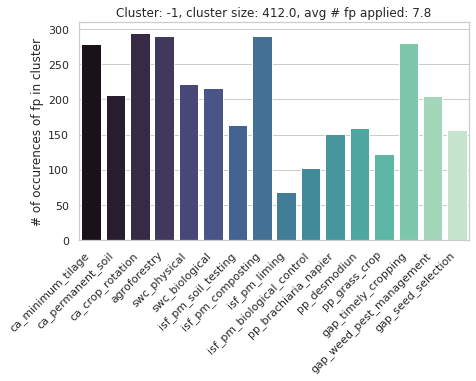

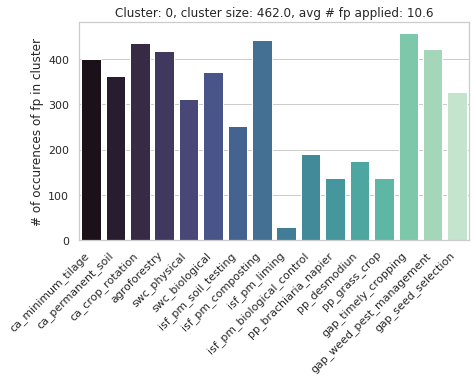

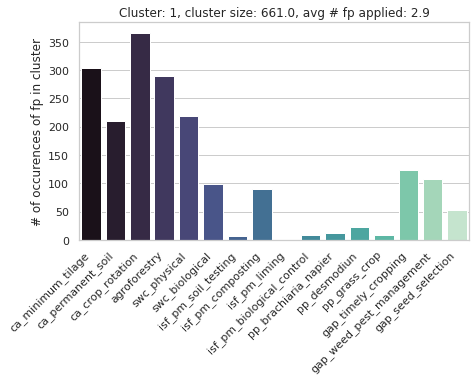

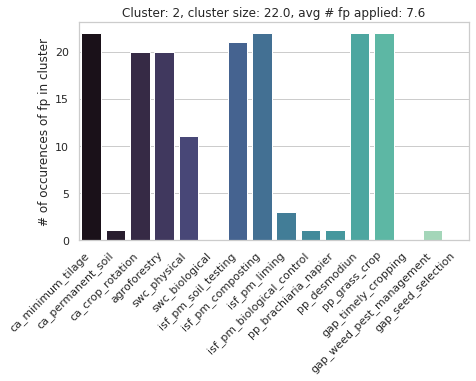

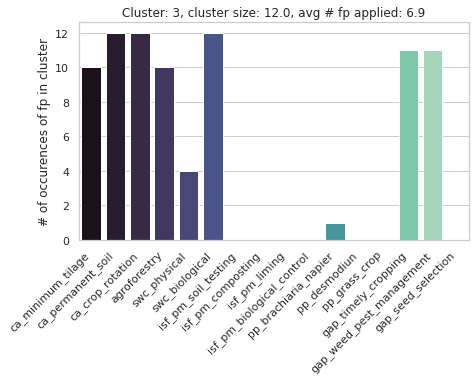

Executing shutdown due to inactivity...
Executing shutdown due to inactivity...
Executing shutdown due to inactivity...


2021-11-24 17:01:51,838 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...
Executing shutdown...
Executing shutdown...


2021-11-24 17:01:51,859 - INFO     - Executing shutdown...


In [128]:
#Plotting the contens of each cluster
sns.set(style="whitegrid", color_codes=True)

labels = farming_practices_no_fertilizer_type
for i, r in grouped.iterrows():
    fig, ax = plt.subplots(figsize=(7,4))
    
    sns.barplot(r[farming_practices_no_fertilizer_type].index, r[farming_practices_no_fertilizer_type].values, palette='mako',ax=ax)
    plt.xticks(rotation=45)
    plt.xticks(ha='right')
    plt.ylabel('# of occurences of fp in cluster')
    plt.title(f"Cluster: {i}, cluster size: {r['ones']}, avg # fp applied: {r['avg_number_practice_applied']:.1f}")
    plt.savefig(f"plots/clustering/cluster{i}.png", bbox_inches = 'tight')
    plt.show()


